## Analyze A/B Test Results

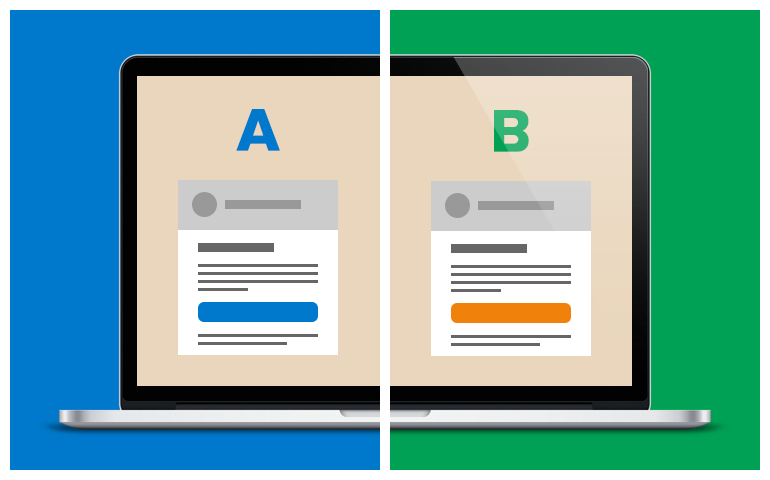

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

In this project I am working on understanding the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. My goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
nomatch1=df.query('group == "treatment" & landing_page == "old_page"')['group'].count()

In [8]:
nomatch2=df.query('group == "control" & landing_page == "new_page"')['group'].count()

In [9]:
nomatch1+nomatch2

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a.Create a new dataset.  Store your new dataframe in **df2**.

In [11]:
t=df.query('group == "treatment" & landing_page == "new_page"')
c=df.query('group == "control" & landing_page == "old_page"')
df2=c.append(t)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.`

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2.duplicated(['user_id'],keep=False)]
#https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/#:~:text=DataFrame.,or%20some%20specific%20columns%20i.e.&text=It%20returns%20a%20Boolean%20Series%20with%20True%20value%20for%20each%20duplicated%20row.

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop_duplicates(subset='user_id',keep='first', inplace=True)

In [17]:
sum(df2.user_id.duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Conclusion:** There is a 50% chance of an individual receiving new or old page. Considering that, we can see that 12% of the people from the control group converted where as 11.8% of people from the treatment group converted. Thus there is no sufficient evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**
Null Hypothesis - New page is no better or even worse than the old page.
                   **$p_{new}$** - **$p_{old}$** <= 0
Alternate Hypothesis - New page is better than the old page.
                     **$p_{new}$** - **$p_{old}$** > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.   <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [33]:
c_pnew=df2.converted.mean()
c_pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [34]:
c_pold=df2.converted.mean()
c_pold

0.11959708724499628

In [35]:
c_pnew-c_pold

0.0

c. What is $n_{new}$, the number of individuals in the treatment group?

In [36]:
n_new=df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [37]:
n_old=df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [85]:
new_page_converted=np.random.choice([0,1],size=n_new,p=[(1-c_pnew),c_pnew])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [86]:
old_page_converted=np.random.choice([0,1],size=n_old,p=[(1-c_pold),c_pold])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [87]:
obs_diff=new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0010346214684094079

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [47]:
p_diffs=[]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=n_new,p=[(1-c_pnew),c_pnew])
    old_page_converted=np.random.choice([0,1],size=n_old,p=[(1-c_pold),c_pold])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

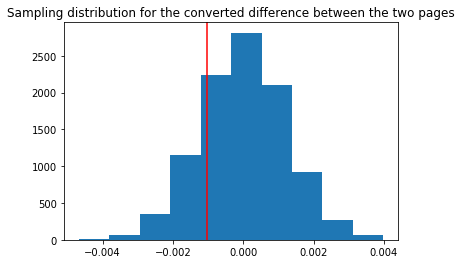

In [88]:
plt.hist(p_diffs)
plt.title('Sampling distribution for the converted difference between the two pages')
plt.axvline(x= obs_diff, c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [89]:
(p_diffs>obs_diff).mean()

0.8044

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** The above calculated value is p-value in scientific terms. As the p-value is 0.8044, which is greater than the threshold value of Type 1 error 0.05 (the type 1 error rate was 5%), we fail to reject the null hypothesis. Thus, there is no sufficient evidence that says that the new page is better than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [90]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1')['converted'].count()
convert_new = df2.query('landing_page == "new_page" & converted == 1')['converted'].count()
n_old = df2.query('landing_page == "old_page"')['landing_page'].count()
n_new = df2.query('landing_page == "new_page"')['landing_page'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [91]:
zstat,p_value=sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old],alternative='larger')
print("z-score:", zstat)
print("p-value:", p_value)

z-score: -1.31092419842
p-value: 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** The computed p-value using the build-in is large, thus we again end up staying with null hypothesis as our choice same as the previous two finding.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [92]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
df2['intercept']=1
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1


In [93]:
df2[['control','ab_page']]=pd.get_dummies(df['group'])
df2=df2.drop('control',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [94]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [95]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:56:54   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Answer:** The p-value associated with ab_page is 0.190.

For Logistic regression, Null hypothesis states that there is no relationship between the conversion and which page a customer receives(ab_page), while the alternative states that there is one. 

In Part II, random sampling was done to get the results. But in regression model we consider all the data points present. Thus we got different p-values. 

Even with this obtained p-value our conclusion remains the same, we fail to reject the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** We have done logistic regression with just one independent variable and concluded that there is no strong relationship between those two, so it would be a better idea to consider other factors to be added to our regression model. Generally speaking, adding an another variable changes the earlier coeficients almost always. 

Yes, there are disadvantages of adding new terms into your model, one of them is multicollinearity in regression. Multicollinearity condition in regression is when the independent variables in the model are correlated with each other. One of the consequence of this is, the coefficients can seem to be insignificant even when a significant relationship exists between the predictor and the response.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [96]:
country_df=pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [97]:
new_df = country_df.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [98]:
new_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [99]:
new_df[['UK','US','CA']]=pd.get_dummies(new_df['country'])
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [100]:
new_df=new_df.drop('CA',axis=1)

In [101]:
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [102]:
log_mod=sm.Logit(new_df['converted'],new_df[['intercept','ab_page','UK','US']])
results=log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:28:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Answer:** As the p-value for all the three predictor variables are still greater than 0.05, they don't seem to have any statistical significance on customer conversion. Thus adding new terms has not made the model any better.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [103]:
#https://statisticsbyjim.com/regression/interaction-effects/
new_df['US_ab_page'] = new_df['US']*new_df['ab_page']
new_df['UK_ab_page'] = new_df['UK']*new_df['ab_page']
new_df.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,1,0


In [104]:
log_mod=sm.Logit(new_df['converted'],new_df[['intercept','ab_page','UK','US','US_ab_page','UK_ab_page']])
results=log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:34:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

In this Analysis of A/B test results, we used different methods to analyze and help the company understand whether they should implement the new page or keep the old page, so that more people convert i.e. more number of users decide to pay for the company's product. 

We obtained different p-values, but none of them were smaller than the Type 1 error rate, so that we could reject the null hypothesis. Thus, based on our analysis we can say that there is no evidence that implementing the new page will get us more conversions. Including new parameters like countries also did not have any significance in our analysis. So maybe can say that running the experiment for a longer time can lead us to new conclusions, and the duration may have more statistical significance in this analysis

In [106]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0